# This Script Performs a Global Sensitivity Analysis for the Predator-Prey Framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Pred - Prey Model Functions

In [2]:
def dNdt(N, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_N = parameters_dict['r_N'] # growth rate of herbivores
    K_N = parameters_dict['K_N'] # carrying capacity of herbivores
    theta_N = parameters_dict['theta_N'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_N = parameters_dict['q_N'] # proportionality constant for herbivore harvest
    E_N = parameters_dict['E_N'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dN = r_N*N*(1-N/K_N) - (c*N*P)/(d+N) + theta_N - q_N*E_N*N
    dP = r_P*P*(1-P/K_P) + (b*N*P)/(d+N) + theta_P - q_P*E_P*P
    
    return dN, dP

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(N, P, parameters_dict):
    N_init = N
    P_init = P 
    
    dN1, dP1 = dNdt(N,P,parameters_dict)
    
    N1 = N + 0.5*dN1
    P1 = P + 0.5*dP1
    
    dN2, dP2 = dNdt(N1,P1,parameters_dict)
    
    dN_ave = (dN1+dN2)/2 
    dP_ave = (dP1+dP2)/2 
    
    N = N_init + dN_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_N = parameters_dict['q_N'] #proportionality constant for herbivore harvest 
    E_N = parameters_dict['E_N'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_N*E_N*N
    predator_harvest = q_P*E_P*P
    
    return N, P, herbivore_harvest, predator_harvest

In [4]:
# Function to run the model 

def run_model(INIT_N, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    N_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    N_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    N_array[0] = INIT_N #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    N_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        N_array[i+1], P_array[i+1], N_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(N_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return N_array, P_array, N_harvest_array, P_harvest_array

## Run Model and Test Plot Trajectories

In [5]:
#Run model simulation
numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_N = 0.4 # growth rate of herbivores
K_N = 5000 # carrying capacity of herbivores
theta_N = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_N = 1. # proportionality constant for herbivore harvest 
E_N = 0.4 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.4 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_N': r_N, 
                  'K_N': K_N, 
                  'theta_N': theta_N,
                  'c': c, 
                  'd': d, 
                  'E_N': E_N,
                  'q_N': q_N, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

N0 = 100
P0 = 10

N_array, P_array, N_harvest_array, P_harvest_array = run_model(N0, P0, parameters_dict)

Text(0.5, 0, 'Time (in years)')

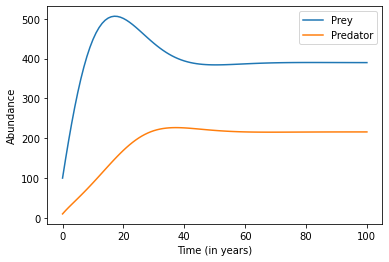

In [6]:
plt.plot(N_array, label='Prey')
plt.plot(P_array, label='Predator')
plt.legend()
plt.ylabel("Abundance")
plt.xlabel("Time (in years)")

## Running through params of interest

In [7]:
#Run model simulation
numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_N = 0.4 # growth rate of herbivores
K_N = 5000 # carrying capacity of herbivores
theta_N = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_N = 1. # proportionality constant for herbivore harvest 
E_N = 0.4 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.4 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_N': r_N, 
                  'K_N': K_N, 
                  'theta_N': theta_N,
                  'c': c, 
                  'd': d, 
                  'E_N': E_N,
                  'q_N': q_N, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

## Function to run through params at +/- 10%

In [8]:
# Function to vary parameters and document all parameter values
def run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, N0, P0):
    # Initialize an empty list to store all results
    all_results = []
    
    # Loop through each parameter to vary
    for param in params_to_vary:
        # Store the original value of the parameter
        original_value = parameters_dict[param]
        
        # Generate values to vary the parameter within the specified range
        varied_values = np.linspace(
            original_value * (1 - variation_range),  # Lower bound
            original_value * (1 + variation_range),  # Upper bound
            1000  # Number of variations (adjustable)
        )
        
        # Loop through each varied value for the current parameter
        for value in varied_values:
            # Update the parameter in the dictionary
            parameters_dict[param] = value
            
            # Run the model with the updated parameters
            N_array, P_array, N_harvest_array, P_harvest_array = run_model(N0, P0, parameters_dict)
            
            # Create a dictionary to store the results for this run
            result = {
                'N_final': N_array[-1],
                'P_final': P_array[-1]
            }
            
            # Add all parameter values to the result
            result.update(parameters_dict)
            
            # Append the result to the list
            all_results.append(result)
        
        # Reset the parameter to its original value
        parameters_dict[param] = original_value
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

## Testing Function to Make Sure it works

In [9]:
# Specify parameters to vary and their variation range
params_to_vary = ['r_N', 'K_N','theta_N', 'c', 'd', 'E_N','q_N','r_P','K_P', 'E_P','q_P', 'theta_P', 'b']  # Parameters to vary
variation_range = 0.75  # Â±75% variation
N0 = 100
P0 = 10


# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, N0, P0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/pred_prey_data.csv', index=False)

           N_final      P_final  numyears       r_N          K_N    theta_N  \
0       140.972707    83.100733       100  0.100000  5000.000000  50.000000   
1       141.193166    83.170088       100  0.100601  5000.000000  50.000000   
2       141.414253    83.239701       100  0.101201  5000.000000  50.000000   
3       141.635969    83.309574       100  0.101802  5000.000000  50.000000   
4       141.858317    83.379707       100  0.102402  5000.000000  50.000000   
5       142.081300    83.450102       100  0.103003  5000.000000  50.000000   
6       142.304919    83.520761       100  0.103604  5000.000000  50.000000   
7       142.529177    83.591685       100  0.104204  5000.000000  50.000000   
8       142.754077    83.662875       100  0.104805  5000.000000  50.000000   
9       142.979621    83.734333       100  0.105405  5000.000000  50.000000   
10      143.205811    83.806060       100  0.106006  5000.000000  50.000000   
11      143.432650    83.878057       100  0.106607 

## Run RF Analysis - Prey

In [10]:
data_prey = pd.read_csv("data/pred_prey_data.csv")

X1 = data_prey.iloc[:, 2:17]  # Columns besides prey abundance are explanatory
Y1 = data_prey.iloc[:, 0]   # Column with prey abundance is response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X1, Y1)

# Predict using the model
predictions = regressor.predict(X1)

# Calculate Mean Squared Error
mse = mean_squared_error(Y1, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y1, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.03524091701615918
R-squared: 0.9999990202712628


In [11]:
importances1 = regressor.feature_importances_

# Set up labels for the features (adjust based on your column names)
plotLabs1 = X1.columns  # Using column names directly for labeling

## Run RF Analysis - Predator

In [12]:
data_predator = pd.read_csv("data/pred_prey_data.csv")

X2 = data_predator.iloc[:, 2:17]  # Columns besides prey abundance are explanatory
Y2 = data_predator.iloc[:, 1]   # Column with prey abundance is response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X2, Y2)

# Predict using the model
predictions = regressor.predict(X2)

# Calculate Mean Squared Error
mse = mean_squared_error(Y2, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y2, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.0386156968651074
R-squared: 0.999999090747747


In [13]:
importances2 = regressor.feature_importances_

# Set up labels for the features (adjust based on your column names)
plotLabs2 = X2.columns  # Using column names directly for labeling

# Plot

In [14]:
plotLabs1 = [f"${label}$" for label in X1.columns]
plotLabs2 = [f"${label}$" for label in X2.columns]

filtered_indices1 = [i for i, label in enumerate(X1.columns) if label != "numyears"]
plotLabs1 = [f"${label}$" for i, label in enumerate(X1.columns) if i in filtered_indices1]
filtered_importances1 = [importances1[i] for i in filtered_indices1]

filtered_indices2 = [i for i, label in enumerate(X2.columns) if label != "numyears"]
plotLabs2 = [f"${label}$" for i, label in enumerate(X2.columns) if i in filtered_indices2]
filtered_importances2 = [importances2[i] for i in filtered_indices2]

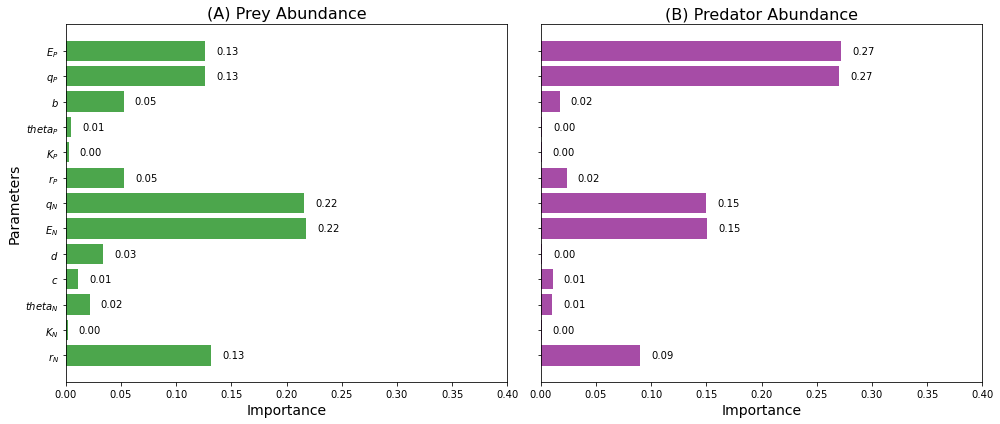

In [16]:
# Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Prey Importance Plot
axes[0].barh(plotLabs1, filtered_importances1, align="center", color = "green", alpha=0.7)
axes[0].set_xlabel("Importance", fontsize = 14)
axes[0].set_ylabel("Parameters", fontsize = 14)
axes[0].set_xlim(0,0.4)
axes[0].set_title("(A) Prey Abundance", fontsize = 16)

for i, v in enumerate(filtered_importances1):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va='center', color="black", fontsize=10)


# Predator Importance Plot
axes[1].barh(plotLabs2, filtered_importances2, align="center", color="purple", alpha=0.7)
axes[1].set_xlabel("Importance", fontsize = 14)
axes[1].set_title("(B) Predator Abundance", fontsize = 16)
axes[1].set_xlim(0,0.4)

for i, v in enumerate(filtered_importances2):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va='center', color="black", fontsize=10)

# Adjust layout
plt.tight_layout()

plt.savefig("manuscript_figs/parameter_importance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()